# Learning Auctions Introduction

In this tutorial, we design, or more aptly learn, auction mechanisms that are approximately revenue optimal while satisfying certain constraints concerning bidder incentives.  The mechanisms themselves will be composed of two networks: an allocation-rule network and a payment-rule network.  This notebook serves as an introduction to the problem domain and focuses on settings were a set of bidders are competing to win a single item via an auction.

## Theoretical framework 
We adopt the framework of [Dutting et al. (2018)](https://arxiv.org/pdf/1706.03459.pdf)

* there are $n$ bidders ($N$) over $m$ items ($M$);
* each bidder $i\in N$ has some value function $v_i: 2^M \rightarrow \mathbb{R}_+$ drawn indepdendently from some distribution $F_i$ over value functions $V_i$;
* the profile of valuations is denoted by $v=(v_1, \ldots, v_n)$;
* the auctioneer knows $F=(F_1, \ldots, F_n)$ but does not know $v$;
* the auctioneer runs a mechanism ($\mathcal{M}=(g,p)$) with allocation rules $g_i: V \rightarrow 2^M$ and payment rules $p_i : V\rightarrow \mathbb{R}_{\ge 0};$
* the auction collects bids $b = (b_1, \ldots , b_n) \in V$, and then computes an allocation $g(b)$ and payments $p(b)$.

We search to design, or more aptly learn, a dominant-strategy incentive-compatible ([DSIC](https://en.wikipedia.org/wiki/Incentive_compatibility)) and individually rational ([IR](https://en.wikipedia.org/wiki/Rational_choice_theory)) mechanism that maximizes expected revenue:

$$
\max_{g,p} E_{v\sim F} \left[\sum_i p(v)\right]\ \ \text{s.t.}\ \ (g,p)\in \text{DISC},\ \ (g,p)\in \text{IR}
$$

The authors encode the DISC and IR constraints as follows:

* DISC: $u_i(v_i, (v_i, b_{−i})) \ge u_i(v_i, (b_i, b_{−i}))$;
* IR: $u_i(v_i,(v_i,b_{−i})) \ge 0$.

## Architectures and supporting functions

### Preliminaries

We will make heavy use of numpy, pandas, and pytorch.

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

We will also make use of matplotlib and seaborn for visualization:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Common components

All mechanism networks will output allocations and payments.  The allocation shape is `[batch_size, bidders+1]`.  The first column represents the probability that the item is not allocated, with all other columns representing the probability that the item is allocated to the respective bidder.  The payment shape is `[batch_size, bidders]`.  Here each column represents the payment of the respective bidder.

We define a generic mechanism as follows:

In [3]:
class MechanismNet(nn.Module):
    def __init__(self, allocation_rule, payment_rule):
        super(MechanismNet, self).__init__()
        self.allocation_rule = allocation_rule
        self.payment_rule = payment_rule
        
    def forward(self, x):
        allocation = self.allocation_rule(x)
        return allocation, allocation[:,1:] * self.payment_rule(x)

Utility can thusly be calculated by:

In [4]:
def calc_utility(bids, mechanism, valuation=None, output_components=False):
    valuation = valuation if valuation is not None else bids
    allocation, payment = mechanism(bids)
    if output_components:
        return allocation[:,1:]*valuation-payment, allocation, payment
    else:
        return allocation[:,1:]*valuation-payment

The `calc_utility` function will return a tensor of shape `[batch_size,bidders]`.

In order to determine if a mechanism is (approximately) DISC, we calculate regret:

In [5]:
def calc_regret(values, mechanism, responders, leaky=False):
    u_true, a_true, p_true = calc_utility(values, mechanism, output_components=True)
    regret = torch.zeros(values.shape).to(device)
    for bidder, responder in enumerate(responders):
        bidder_mask = torch.zeros(values.shape).to(device)
        bidder_mask[:,bidder] = 1.0
        response = responder(values, a_true, p_true)
        u_response = calc_utility(response, mechanism, values)
        if leaky:
            regret = regret + F.leaky_relu((u_response - u_true) * bidder_mask)
        else:
            regret = regret + F.relu((u_response - u_true) * bidder_mask)
    return regret.mean(dim=0)

Finally, we can define the training function.

In [6]:
import torch.optim as optim
import torch.utils.data as data_utils
from tqdm import tqdm

def train(mechanism, responders, values_loader, epochs=1, rho=100, clipping_norm=None):
    # Initialize augmented lagrangian parameters
    lambda_dsic = torch.zeros(bidders).to(device)
    lambda_ir   = torch.zeros(bidders).to(device)

    # Initalize the optimizer
    mechanism_optimizer = optim.Adam(mechanism.parameters(), lr=1e-4)
    responder_optimizers = [optim.Adam(r.parameters(), lr=1e-4) for r in responders]
    report_data = []

    for epoch in tqdm(range(epochs)):
        for batch_idx,(values_list) in enumerate(values_loader):
            values = values_list[0].to(device)
            
            # calculate the utilities and prices
            utility, allocation, payment = calc_utility(
                values, mechanism, output_components=True)
    
            # compute expected regret 
            dsic_violation = calc_regret(
                values, 
                mechanism,
                responders)
    
            # compute individual rationality violation
            ir_violation = F.relu(-utility).mean(dim=0)
    
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
            total_dsic_violation = dsic_violation.sum()
            total_ir_violation = ir_violation.sum()
    
            # Start the gradient computation
            mechanism.zero_grad()
    
            # define the loss 
            loss = -revenue\
                +(lambda_dsic*dsic_violation).sum()\
                +(lambda_ir*ir_violation).sum()\
                +0.5*rho*(total_dsic_violation.pow(2)+total_ir_violation.pow(2))
    
            # Trigger the autogradient calculation
            loss.backward()
        
            # Take a step towards the gradient
            mechanism_optimizer.step()
            
            with torch.no_grad():
                mechanism.eval()
                for responder in responders:
                    responder.eval()
                    
                # Update the augmented lagrangian parameters
                dsic_violation_next = calc_regret(
                    values,
                    mechanism,
                    responders)
                u_next = calc_utility(values, mechanism)
                ir_violation_next = F.relu(-u_next).mean(dim=0)
                lambda_dsic = lambda_dsic + rho * dsic_violation_next
                lambda_ir = lambda_ir + rho * ir_violation_next
                mechanism.train()
                for responder in responders:
                    responder.train()
            
            report_data.append({
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item(),
                'total_dsic_violation':total_dsic_violation.item(),
                'total_ir_violation':total_ir_violation.item(),
                'loss':loss.item()})
            
            for bidder, responder in enumerate(responders):
                optimizer = responder_optimizers[bidder]
                optimizer.zero_grad()
                regret = calc_regret(
                    values, 
                    mechanism,
                    responders,
                    leaky=True)
                (-regret[bidder]).backward()
                optimizer.step()
            
    return pd.DataFrame(report_data)     

## Responder

The responder network computes the best response to the mechanism.

In [7]:
class Responder(nn.Module):
    def __init__(self, bidder, hidden_units):
        super(Responder, self).__init__()
        self.bidder = bidder
        self.initial_layer = nn.Linear(2, hidden_units)
        self.hidden_layer = nn.Linear(hidden_units, hidden_units)
        self.final_layer = nn.Linear(hidden_units, 1)
        
    def forward(self, values, allocation, payment):
        x = torch.cat((allocation[:,self.bidder+1].unsqueeze(1), payment[:,self.bidder].unsqueeze(1)), dim=1)
        x = F.leaky_relu(self.initial_layer(x))
        x = F.leaky_relu(self.hidden_layer(x))
        x = torch.sigmoid(self.final_layer(x))
        bidder_mask = torch.zeros(values.shape).to(device)
        bidder_mask[:,self.bidder] = 1.0
        return (1-bidder_mask)*values + bidder_mask * values * x

## RegretNet

[Dutting et al. (2018)](https://arxiv.org/pdf/1706.03459.pdf) proposed a network of the following form.  We give a pytorch implementation of the network with minor modifications to the activation funtions.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

The allocation network is defined as follows:

In [9]:
class RegretNetAllocation(nn.Module):
    def __init__(self, bidders, hidden_layers, hidden_units):
        super(RegretNetAllocation, self).__init__()
        assert hidden_layers > 0
        fc_layers = []
        fc_layers.append(nn.Linear(bidders, hidden_units))
        if hidden_layers > 1:
            for _ in range(hidden_layers-1):
                fc_layers.append(nn.Linear(hidden_units, hidden_units))
        fc_layers.append(nn.Linear(hidden_units, bidders+1))
        self.fc_layers = nn.ModuleList(fc_layers)
        
    def forward(self, x):
        for layer in self.fc_layers[:-1]:
            x = F.leaky_relu(layer(x))
        return F.softmax(self.fc_layers[-1](x), dim=1)

The payment network is defined as follows:

In [10]:
class RegretNetPayment(nn.Module):
    def __init__(self, bidders, hidden_layers, hidden_units):
        super(RegretNetPayment, self).__init__()
        assert hidden_layers > 0
        fc_layers = []
        fc_layers.append(nn.Linear(bidders, hidden_units))
        if hidden_layers > 1:
            for _ in range(hidden_layers-1):
                fc_layers.append(nn.Linear(hidden_units, hidden_units))
        fc_layers.append(nn.Linear(hidden_units, bidders))
        self.fc_layers = nn.ModuleList(fc_layers)
        
    def forward(self, x):
        for layer in self.fc_layers:
            x = F.leaky_relu(layer(x))
        return x

Finally, we can define the RegretNet mechanism.  Note that the output activation function used by Dutting et al. was the `relu`.  In the examples below we use `leaky_relu`.

In [11]:
def create_regret_net(bidders, hidden_layers=2, hidden_units=100):
    return MechanismNet(
        RegretNetAllocation(bidders, hidden_layers, hidden_units),
        RegretNetPayment(bidders, hidden_layers, hidden_units))

## Single-Item Auction

In the samples below, we evaluate RegretNet on standard auction scenarios.  In each case, bidders valuations are drawn independently from $U[0,1]$.

### Single Bidder

For our warmup exercise, we consider only a single bidder.  From Myerson (81), we know that the optimal mechanism is a fixed price of 0.5.  Since the bidders values are drawn from uniformly from [0,1], we know that half of the draws will result in the bidder passing on the item, with the other half accepting at a price of 0.5.  Therefore, the optimal expected revenue is 0.25.

In [12]:
bidders = 1

The networks will train on data that is sampled from the value distribution, which is loaded into a `DataLoader`.

In [13]:
sample_size = 2**11
batch_size = 2**8

values_loader=data_utils.DataLoader(
    data_utils.TensorDataset(torch.rand(sample_size, bidders)),
    batch_size=batch_size)

We consider both the mechanism and responder networks.

In [14]:
regret_net = create_regret_net(bidders).to(device)
regret_net_responders = [Responder(bidder, 100).to(device) for bidder in range(bidders)]

We loop over the data for a number of epochs and record traces of the networks learning.

In [15]:
epochs = 1000
report = train(regret_net, regret_net_responders, values_loader, epochs=epochs)

100%|██████████| 1000/1000 [03:11<00:00, 11.41it/s]


First, let's review the IR violations of the network.  In the figure below, we can see that RegretNet quickly optimizes to vanishingly small IR violations.

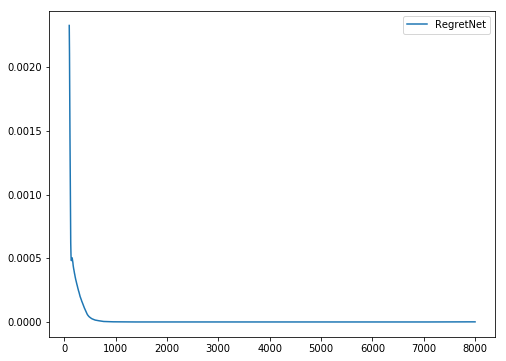

In [17]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(report[['total_ir_violation']].rolling(100).mean(), label='RegretNet');
ax.legend();

Next, let's review the DSIC violations. RegretNet quickly optimizes to epsilon violations.

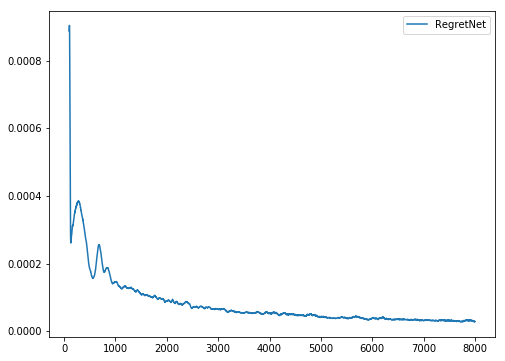

In [18]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(report[['total_dsic_violation']].rolling(100).mean(), label='RegretNet');
ax.legend();

Finally, let's review the revenue.  Regrent quickly converges to the optimal revenue.

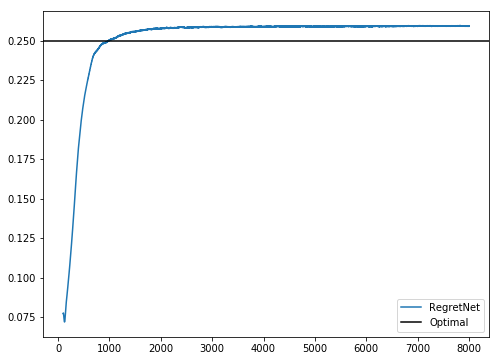

In [19]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(report[['revenue']].rolling(100).mean(), label='RegretNet');
ax.axhline(0.25, c='k', label='Optimal')
ax.legend();

### Two Bidders

For our warmup exercise, we consider only a single bidder.  From Myerson (81), we know that the optimal mechanism is a fixed price of 0.5.  Since the bidders values are drawn from uniformly from [0,1], we know that half of the draws will result in the bidder not winning the item, with the other half winning at a price of 0.5.  Therefore, the optimal expected revenue is 0.25.

In [20]:
bidders = 2

Again, the networks will train on data that is sampled from the value distribution, which is loaded into a `DataLoader`.

In [21]:
sample_size = 2**11
batch_size = 2**8

values_loader=data_utils.DataLoader(
    data_utils.TensorDataset(torch.rand(sample_size, bidders)),
    batch_size=batch_size)

We again initialize the mechanism and responder networks.

In [22]:
regret_net = create_regret_net(bidders).to(device)
regret_responders = [Responder(bidder, 100).to(device) for bidder in range(bidders)]

As above, we loop over the data for a number of epochs and record traces of the networks learning.

In [23]:
epochs = 1000
report = train(regret_net, regret_responders, values_loader, epochs=epochs, rho=100)

100%|██████████| 1000/1000 [05:00<00:00,  2.13it/s]


RegretNet quickly conversions to minimal IR violations.

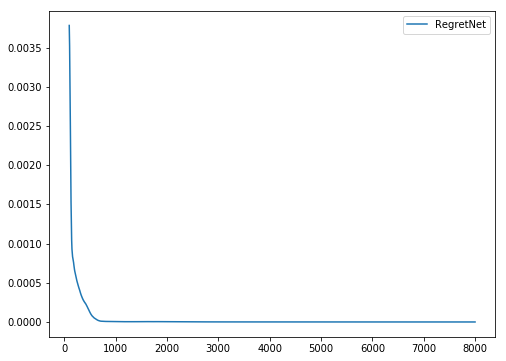

In [24]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(report[['total_ir_violation']].rolling(100).mean(), label='RegretNet');
ax.legend();

ShadeNet quickly settles into low DCIS violation, whereas RegretNet spikes and then quickly vanishes.

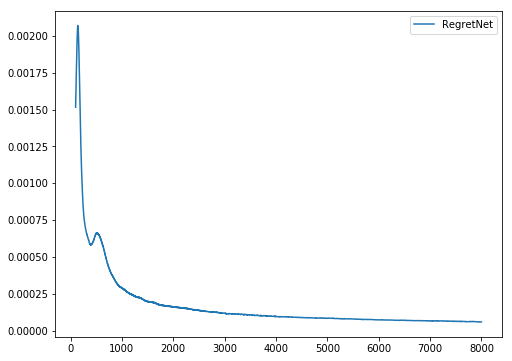

In [25]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(report[['total_dsic_violation']].rolling(100).mean(), label='RegretNet');
ax.legend();

RegretNet quickly finds the optimal revenue.

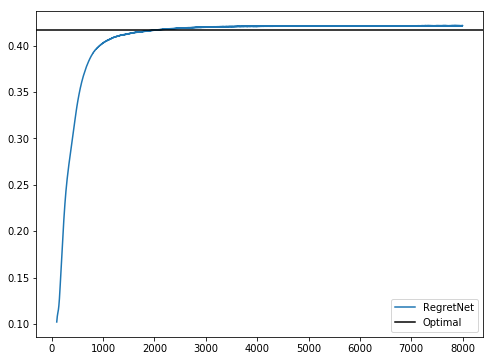

In [26]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(report[['revenue']].rolling(100).mean(), label='RegretNet');
ax.axhline(5/12, c='k', label='Optimal')
ax.legend();